In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold, LeaveOneGroupOut, StratifiedKFold
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import statsmodels.formula.api as smf
from tqdm import tqdm
import itertools
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
from sklearn.metrics import r2_score

In [2]:
# dask cluster location
cluster_loc = 'local'
prefix = 'plot'
tuneby = 'year'

inDIR = '../data/training/'
inFILE = 'vor_2013_2022_cln_2023_08_29_' + prefix + '_hls_idxs.csv'

with open('results/ml_train_' + prefix + '_cv_year_tuneby_' + tuneby + '_results.pk', 'rb') as f:
    mod_dict = pickle.load(f)

inPATH = os.path.join(inDIR, inFILE)

lr_mod = pickle.load(open("../models/biomass/CPER_HLS_to_VOR_biomass_model_lr_simp.pk", 'rb'))

outDIR = './results/'

var_names = ['dfi', 'ndvi', 'ndti', 'satvi', 'ndii7', 
             'savi', 'rdvi', 'mtvi1', 'nci', 'ndci', 'psri', 'ndwi', 'evi', 'tcbi', 'tcgi', 'tcwi',
             'blue', 'green', 'red', 'nir', 'swir1', 'swir2',
             'bai_126', 'bai_136', 'bai_146', 'bai_236', 'bai_246', 'bai_346']

var_dict = {
    'NDVI': 'ndvi',
    'DFI': 'dfi',
    'NDTI': 'ndti',
    'SATVI': 'satvi',
    'NDII7': 'ndii7',
    'SAVI': 'savi',
    'RDVI': 'rdvi',
    'MTVI1': 'mtvi1', 
    'NCI': 'nci', 
    'NDCI': 'ndci',
    'PSRI': 'psri',
    'NDWI': 'ndwi',
    'EVI': 'evi',
    'TCBI': 'tcbi',
    'TCGI': 'tcgi',
    'TCWI': 'tcwi',
    'BAI_126': 'bai_126',
    'BAI_136': 'bai_136',
    'BAI_146': 'bai_146',
    'BAI_236': 'bai_236',
    'BAI_246': 'bai_246',
    'BAI_346': 'bai_346',
    'BLUE': 'blue',
    'GREEN': 'green',
    'RED': 'red',
    'NIR1': 'nir',
    'SWIR1': 'swir1',
    'SWIR2': 'swir2'
}

rand_st = 2313

In [3]:
def r2_corrcoef(y_obs, y_pred):
    try:
        corr_matrix = np.corrcoef(y_obs, y_pred)
        corr = corr_matrix[0,1]
        R_sq = corr**2
    except RuntimeError:
        R_sq = 'Error'
    return R_sq

In [4]:
backend = 'threading'

In [5]:
df_vor = pd.read_csv(inPATH, parse_dates=[2, 3])
df_vor = df_vor.rename(columns=var_dict)

In [6]:
df_vor = df_vor[df_vor['Season'].isin(['June', 'October'])].copy()
#df_vor = df_vor[df_vor['Year'] >= 2017].copy()

In [7]:
# check for any missing data
len(df_vor[df_vor[var_names].isnull().any(axis=1)])

0

In [8]:
# remove missing data
df_vor = df_vor[~df_vor[var_names].isnull().any(axis=1)].copy()
#df_vor = df_vor[~df_vor['Id'].isin(df_vor[df_vor[var_names].isnull().any(axis=1)]['Id'].unique())].copy()

In [9]:
X_vars_all = df_vor[var_names]
Y_var_all = df_vor['Biomass_kg_ha']

In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, LinearRegression, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

In [11]:
os.environ["PYTHONWARNINGS"] = 'ignore'# 'ignore::sklearn.exceptions.ConvergenceWarning:sklearn.model_selection.GridSearchCV'
import multiprocessing
import warnings
multiprocessing.cpu_count()


96

In [12]:
scaler = StandardScaler()
mod_logo = LeaveOneGroupOut()
mod_groupk = GroupKFold(n_splits=10)
scoring = {'R2': 'r2', 'MSE': 'neg_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error'}

In [13]:
from joblib import parallel_backend
import warnings
from sklearn.exceptions import ConvergenceWarning
import time
from sklearn.metrics import r2_score

In [14]:
for k in mod_dict:
    param_best = {}
    param_best_dict = {p: [] for p in mod_dict[k]['param_grid'].keys()}
    for y in mod_dict[k]['tune_results'].keys():
        param_best_dict_tmp = mod_dict[k]['tune_results'][y]['params'][mod_dict[k]['tune_results'][y]['mean_test_' + mod_dict[k]['tune_refit']].argmax()]
        for p in param_best_dict_tmp.keys():
            param_best_dict[p].append(param_best_dict_tmp[p])
    #print(param_best_dict)
    for p in param_best_dict:
        if all([type(i) in [float, np.float64] for i in param_best_dict[p]]):
            param_best[p] = np.mean(param_best_dict[p])
        elif all([type(i) in [int, np.int64] for i in param_best_dict[p]]):
            param_best[p] = int(np.mean(param_best_dict[p]))
        elif all([i is None for i in param_best_dict[p]]):
            param_best[p] = None
        else:
            print('ERROR')
    mod_dict[k]['param_best'] = param_best

In [104]:
yr_test = [2016]
yr_train = [2017, 2018, 2019, 2020]	
yr_combo = yr_train + yr_test
yr_n = len(yr_combo)
k = 'LASSO'

In [105]:
df_results_yrs = pd.DataFrame(columns=['Model', 'numb_yrs', 'yr_train', 'yr_test',
                                       'MAE_kg', 'MAPE', 'MAE_pct', 'R2', 'r2_coef', ])

In [114]:
df_vor_sub = df_vor[df_vor['Year'].isin(yr_combo)]
train_index = df_vor_sub[df_vor_sub['Year'].isin(yr_train)].index
test_index = df_vor_sub[df_vor_sub['Year'].isin(yr_test)].index

all_y_orig = Y_var_all.loc[train_index]
all_Y_orig = Y_var_all.loc[test_index]
all_x_orig = df_vor_sub[var_names].loc[train_index, :]
all_X_orig = df_vor_sub[var_names].loc[test_index, :]

In [115]:
all_y_orig

976     1237
977     1364
978     2086
979      959
980      974
        ... 
2463     211
2464     225
2465     442
2466     212
2467     263
Name: Biomass_kg_ha, Length: 936, dtype: int64

In [109]:
for k in ['PLS']:
    if mod_dict[k]['fit']:
        t0 = time.time()
        if mod_dict[k]['log_y']:
            all_y = np.log(1 + all_y_orig)
            all_Y = np.log(1 + all_Y_orig)
        else:
            all_y = all_y_orig.copy()
            all_Y = all_Y_orig.copy()
        if mod_dict[k]['scale_x']:
            scaler.fit(all_x_orig)
            all_x = scaler.transform(all_x_orig)
            all_X = scaler.transform(all_X_orig)
        else:
            all_x = all_x_orig.copy()
            all_X = all_X_orig.copy()
    
        # create a base model
        mod_base = mod_dict[k]['base_mod']
        # set parameters
        if mod_dict[k]['tune']:
            if tuneby == 'year':
                cv_splitter = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.loc[train_index])
            elif tuneby == 'pasture':
                cv_splitter = mod_groupk.split(all_x, groups=df_vor['Pasture'].loc[train_index])
            grid_search = GridSearchCV(estimator=mod_base,
                                               param_grid=mod_dict[k]['param_grid'],
                                               scoring=scoring, 
                                               refit=mod_dict[k]['tune_refit'], 
                                               return_train_score=True,
                                               cv=10, 
                                               n_jobs=-1, 
                                               verbose=0)
            with parallel_backend(backend):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=ConvergenceWarning)
                    grid_search.fit(all_x, all_y)
            mod_fnl = mod_base.set_params(**grid_search.best_params_)
            mod_fnl.fit(all_x, all_y)
            param_results = grid_search.cv_results_
        else:
            mod_fnl = mod_base
            mod_fnl.fit(all_x, all_y)
        # fit model
    
        mod_fnl.fit(all_x, all_y)
    
        if mod_dict[k]['log_y']:
            preds = np.exp(mod_fnl.predict(all_X).squeeze()) + 1
        else:
            preds = mod_fnl.predict(all_X).squeeze()
    
        mae_kg_tmp = np.nanmean(np.abs(preds - all_Y_orig))
        mape_tmp = np.nanmean(np.abs(preds - all_Y_orig) / all_Y_orig)
        mae_pct_tmp = mae_kg_tmp / np.nanmean(all_Y_orig)
        r2_tmp = r2_score(all_Y_orig, preds).round(3)
        r2_corr_tmp = r2_corrcoef(all_Y_orig, preds).round(3)
        df_results_yrs = pd.concat([df_results_yrs,
                                    pd.DataFrame({'Model': k,
                                                  'numb_yrs': [yr_n - 1],
                                                  'yr_train': [df_vor_sub['Date'].dt.year.loc[train_index].unique()],
                                                  'yr_test': [df_vor_sub['Date'].dt.year.loc[test_index].unique()],
                                                  'MAE_kg': mae_kg_tmp,
                                                  'MAPE': mape_tmp,
                                                  'MAE_pct': mae_pct_tmp,
                                                  'R2': r2_tmp,
                                                  'r2_coef': r2_corr_tmp},
                                                 index=[idx_ct])])
        idx_ct += 1
    else:
        continue

In [110]:
df_results_yrs

,Model,numb_yrs,yr_train,yr_test,MAE_kg,MAPE,MAE_pct,R2,r2_coef
6,PLS,4,"[2017, 2018, 2019, 2020]",2020,220.8512,0.208091,0.196912,0.63,0.636
7,PLS,4,"[2017, 2018, 2019, 2020]",[2016],220.8512,0.208091,0.196912,0.63,0.636


In [122]:
df_results_yrs = pd.DataFrame(columns=['Model', 'numb_yrs', 'yr_train', 'yr_test',
                                       'MAE_kg', 'MAPE', 'MAE_pct', 'R2', 'r2_coef', ])

In [124]:
idx_ct = 0
df_vor_sub = df_vor[df_vor['Year'].isin(yr_combo)]
#train_index = df_vor_sub[df_vor_sub['Year'].isin(yr_train)].reset_index().index
#test_index = df_vor_sub[df_vor_sub['Year'].isin(yr_test)].reset_index().index
for train_index, test_index in mod_logo.split(df_vor_sub, groups=df_vor_sub['Year']):
    yr = df_vor_sub['Date'].dt.year.iloc[test_index].unique()[0]
    
    train_loc = df_vor_sub.iloc[train_index].index
    test_loc = df_vor_sub.iloc[test_index].index
    
    all_y_orig = df_vor_sub['Biomass_kg_ha'].iloc[train_index]
    all_Y_orig = df_vor_sub['Biomass_kg_ha'].iloc[test_index]
    all_x_orig = df_vor_sub[var_names].iloc[train_index, :]
    all_X_orig = df_vor_sub[var_names].iloc[test_index, :]
    
    for k in ['PLS']:
        if mod_dict[k]['fit']:
            t0 = time.time()
            if mod_dict[k]['log_y']:
                all_y = np.log(1 + all_y_orig)
                all_Y = np.log(1 + all_Y_orig)
            else:
                all_y = all_y_orig.copy()
                all_Y = all_Y_orig.copy()
            if mod_dict[k]['scale_x']:
                scaler.fit(all_x_orig)
                all_x = scaler.transform(all_x_orig)
                all_X = scaler.transform(all_X_orig)
            else:
                all_x = all_x_orig.copy()
                all_X = all_X_orig.copy()
        
            #if mod_dict[k]['interactions']:
            #    poly_x = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
            #                                interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
            #    all_x = poly_x.fit_transform(all_x)
            #    poly_X = PolynomialFeatures(degree=mod_dict[k]['interaction_poly'], 
            #                                interaction_only=mod_dict[k]['interaction_only'], include_bias = False)
            #    all_X = poly_X.fit_transform(all_X)
            #    var_names_out = poly_x.get_feature_names_out(var_names)
            #else:
            #    var_names_out = var_names
    
            # create a base model
            mod_base = mod_dict[k]['base_mod']
            # set parameters
            if mod_dict[k]['tune']:
                if tuneby == 'year':
                    cv_splitter = mod_logo.split(all_x, groups=df_vor['Date'].dt.year.iloc[train_index])
                elif tuneby == 'pasture':
                    cv_splitter = mod_groupk.split(all_x, groups=df_vor['Pasture'].iloc[train_index])
                grid_search = GridSearchCV(estimator=mod_base,
                                                   param_grid=mod_dict[k]['param_grid'],
                                                   scoring=scoring, 
                                                   refit=mod_dict[k]['tune_refit'], 
                                                   return_train_score=True,
                                                   cv=10, 
                                                   n_jobs=-1, 
                                                   verbose=0)
                with parallel_backend(backend):
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", category=ConvergenceWarning)
                        grid_search.fit(all_x, all_y)
                mod_fnl = mod_base.set_params(**grid_search.best_params_)
                mod_fnl.fit(all_x, all_y)
                param_results = grid_search.cv_results_
            else:
                mod_fnl = mod_base
                mod_fnl.fit(all_x, all_y)
            # fit model
        
            mod_fnl.fit(all_x, all_y)
        
            if mod_dict[k]['log_y']:
                preds = np.exp(mod_fnl.predict(all_X).squeeze()) + 1
            else:
                preds = mod_fnl.predict(all_X).squeeze()
        
            mae_kg_tmp = np.nanmean(np.abs(preds - all_Y_orig))
            mape_tmp = np.nanmean(np.abs(preds - all_Y_orig) / all_Y_orig)
            mae_pct_tmp = mae_kg_tmp / np.nanmean(all_Y_orig)
            r2_tmp = r2_score(all_Y_orig, preds).round(3)
            r2_corr_tmp = r2_corrcoef(all_Y_orig, preds).round(3)
            df_results_yrs = pd.concat([df_results_yrs,
                                        pd.DataFrame({'Model': k,
                                                      'numb_yrs': [yr_n - 1],
                                                      'yr_train': [df_vor_sub['Date'].dt.year.iloc[train_index].unique()],
                                                      'yr_test': yr,
                                                      'MAE_kg': mae_kg_tmp,
                                                      'MAPE': mape_tmp,
                                                      'MAE_pct': mae_pct_tmp,
                                                      'R2': r2_tmp,
                                                      'r2_coef': r2_corr_tmp},
                                                     index=[idx_ct])])
            idx_ct += 1
        else:
            continue

In [126]:
df_results_yrs

,Model,numb_yrs,yr_train,yr_test,MAE_kg,MAPE,MAE_pct,R2,r2_coef
0,PLS,4,"[2017, 2018, 2019, 2020]",2016,220.8512,0.208091,0.196912,0.63,0.636
1,PLS,4,"[2016, 2018, 2019, 2020]",2017,304.486223,0.381649,0.328324,-0.008,0.502
2,PLS,4,"[2016, 2017, 2019, 2020]",2018,216.052995,0.24028,0.223957,0.565,0.602
3,PLS,4,"[2016, 2017, 2018, 2020]",2019,228.466429,0.249295,0.278982,0.03,0.549
4,PLS,4,"[2016, 2017, 2018, 2019]",2020,123.475578,0.26686,0.255036,0.44,0.463


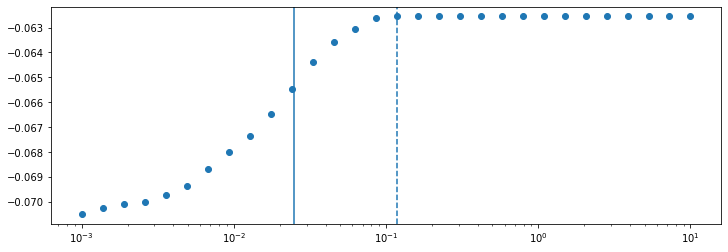

In [67]:
plt.figure(figsize=(12, 4))
plt.scatter(param_results['param_alpha'], param_results['mean_test_MAPE'])
plt.xscale('log')
plt.axvline(mod_dict[k]['param_best']['alpha'])
plt.axvline(grid_search.best_params_['alpha'], linestyle='dashed')

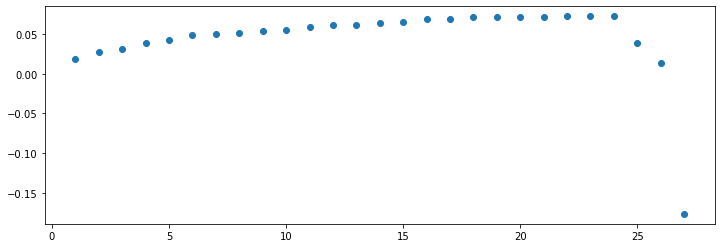

In [97]:
plt.figure(figsize=(12, 4))
plt.scatter(param_results['param_n_components'], param_results['mean_train_R2'])
#plt.axvline(mod_dict[k]['param_best']['n_components'])
#plt.axvline(grid_search.best_params_['n_components'], linestyle='dashed')

In [89]:
grid_search.cv_results_

{'mean_fit_time': array([0.18360527, 0.31397445, 0.41183102, 0.51049869, 0.53918803,
        0.57207086, 0.68125792, 0.70899606, 0.82623332, 0.9195184 ,
        1.04294918, 1.02126777, 0.96090236, 1.00893433, 1.02372148,
        1.19713948, 1.34962225, 1.46315646, 1.35794349, 1.2751909 ,
        1.43357568, 1.40546849, 1.81528504, 1.85724156, 1.90630896,
        1.59734173, 0.98187437]),
 'std_fit_time': array([0.06476427, 0.09684421, 0.11088606, 0.14235525, 0.1185137 ,
        0.13428537, 0.14857776, 0.15871659, 0.16241192, 0.19038347,
        0.11973357, 0.16037166, 0.1133004 , 0.11142035, 0.18375683,
        0.20729502, 0.16750461, 0.1241673 , 0.16814403, 0.2040276 ,
        0.11032179, 0.1895262 , 0.25397301, 0.14232555, 0.19236205,
        0.17417472, 0.2238724 ]),
 'mean_score_time': array([0.08382921, 0.06533351, 0.05641584, 0.04759464, 0.03914859,
        0.03190777, 0.02490721, 0.02402155, 0.0249939 , 0.02539082,
        0.02992747, 0.02156549, 0.03258853, 0.03857265, 0.039809

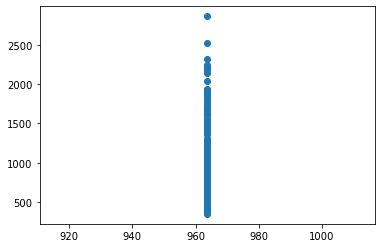

In [68]:
plt.scatter(preds, all_Y_orig)

In [70]:
lasso_coefs = abs(mod_fnl.coef_)
var_names_out = [x for idx, x in enumerate(var_names_out) if abs(lasso_coefs[idx]) != 0.0]
lasso_coefs = lasso_coefs[abs(lasso_coefs) > 0.0]
lasso_coefs_df = pd.DataFrame({'Year': str(df_vor['Date'].dt.year.iloc[test_index].unique()[0]),
                                                      'Variable': var_names_out,
                                                      'Coef': lasso_coefs})

In [71]:
lasso_coefs_df

,Year,Variable,Coef


In [75]:
mod_fnl.coef_

array([ 0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,
        0., -0., -0.,  0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
       -0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,
       -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0.,  0., -0.,  0., -0., -0.,
        0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0.,
        0.,  0., -0., -0., -0., -0., -0., -0.,  0., -0., -0.,  0., -0.,
       -0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0.,
       -0., -0., -0., -0., -0.,  0., -0., -0.,  0., -0., -0.,  0.,  0.,
        0.,  0.,  0.,  0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0